In [1]:
import random
import numpy as np
import math
from scipy.stats import lognorm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'

%matplotlib inline
%run helperfx

run_notebook=False

In [2]:
# Edit these values when using this notebook
use_real_data = False
simulate_data = True
fit_data = False

# set parameters for simulated data
if simulate_data:
    PP = 0.5
    alpha = 40
    beta = 0.5
    intercept = 0.3

# set bounds for fitting data
if fit_data:
    bounds = {'alpha':[1, 105, 20], 'intercept':[0, 0.55, 10]}

    boundbins = []
    boundbins.append(np.arange(bounds['alpha'][0], bounds['alpha'][1], bounds['alpha'][1]/bounds['alpha'][2]))
    boundbins.append(np.arange(bounds['intercept'][0], bounds['intercept'][1], bounds['intercept'][1]/bounds['intercept'][2]))

if use_real_data and simulate_data:
    print('Over-riding simulate_data because use_real_data is selected.')
    simulate_data = False

In [3]:
# This function will be called when simulating test data and data for performing fits

def runmodel(alpha, beta, intercept, nruns):
    
    # Create system with vars of interest
    System = {}
    System['PP'] = PP
    System['alpha'] = alpha
    System['beta'] = beta
    System['intercept'] = intercept
    System['licksinburst'] = 0
    
    # Initializes array for storing data
    output = [0.5]
    
    # for lognormal update func
    sigma = 0.9
    System['dist'] = lognorm(sigma)

    for i in range(1, nruns):
        update_func(System, output)
    
    return output

In [4]:
def update_func(System, licks):
    pp = System['PP']
    alpha = System['alpha']
    beta = System['beta']
    i = System['intercept']
    L = System['licksinburst']
    dist = System['dist']
    
    if licks[-1] == 0.5:
            if random.random() < pp:
                licks.append(1)            
            else:
                licks.append(0)
            System['licksinburst'] = L+1
    else:
        p_cont = dist.pdf(L/alpha+beta)+i
        if random.random() < p_cont:           
            licks.append(licks[-1])
            System['licksinburst'] = L+1
        else:
            licks.append(0.5)
            System['licksinburst'] = 0        

In [5]:
def analyse_licks(data, bins):
    
    caslicks = len([x for x in data if x == 1])
    maltlicks = len([x for x in data if x == 0])
    realPP = caslicks/(caslicks + maltlicks)
    
    burstarray = []
    tmp = []
    for i, x in enumerate(data):
        if x == 0.5:
            burstarray.append(tmp)
            tmp = []
        else:
            tmp.append(x)
    
    bursts = []
    hists = []
    cumsums = []
    cumsums_norm = []
    
    for code in [0, 1]: 
        b = [len(x) for x in burstarray[1:] if x[0]==code]
        h = np.histogram(b, bins=bins) # add binsize
        cs = np.cumsum(h[0])

        bursts.append(b)
        hists.append(h)
        cumsums.append(cs)
        
    cumsums_norm.append([(x/cumsums[0][-1])*(1-realPP) for x in cumsums[0]]) # makes cumsums norm'd to toal licks
    cumsums_norm.append([(x/cumsums[1][-1])*(realPP) for x in cumsums[1]])
    
    return ({'licks':data, 'bursts':bursts, 'hists':hists, 'cumsums':cumsums, 'cumsums_norm':cumsums_norm, 'realPP':realPP })

In [6]:
histbins = np.arange(0,100)

licks = runmodel(alpha, beta, intercept, 5000)
lickdata = analyse_licks(licks, histbins)


In [7]:
def timecourseFig(lickdata, ax=[]):

    x1 = [i for i, x in enumerate(lickdata['licks']) if x == 1]
    x2 = [i for i, x in enumerate(lickdata['licks']) if x == 0]

    y1 = [1]*len(x1)
    y2 = [0]*len(x2)

    ax.plot(x1,y1, 'x')
    ax.plot(x2,y2, 'x')

    # plots real PP
    x1=0; x2=len(lickdata['licks']); y=lickdata['realPP']
    ax.plot([x1, x2], [y, y], linestyle='dashed')
    ax.text(x2,y,'Real PP', va='center' )
    
    if fit_data:
        print('Fitted')
        ax.plot(np.arange(0,len(licks)),[fitted['pp_EV']]*len(licks), 'r', linestyle='dashed')

    #ax.plot(smooth(licks, 50), 'b')
    ax.plot(smooth2(lickdata['licks'], 50), 'r')

    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('Licks')
    ax.set_ylabel('PP')
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Malto', '0.5', 'Casein'])

def histoFig(lickdata, smooth=0, ax=[]):
    
    for index, color in zip([1,0], ['blue', 'orange']):
        x = lickdata['hists'][index][1][1:-1]
        y = lickdata['hists'][index][0][1:]
        
        
        if smooth > 0:
            ax.plot(smooth2(y, smooth))
        else:
            ax.plot(x,y, c=color)
            
        ax.set_xlabel('Licks in burst')
        ax.set_ylabel('Frequency')
        
    cas = lickdata['bursts'][1]
    malt = lickdata['bursts'][0]
    meanCas = 'Casein={:} total bursts\nwith {:.1f} licks/burst'.format(len(cas), np.mean(cas))
    
    meanMalto = 'Malto={:} total bursts\nwith {:.1f} licks/burst'.format(len(malt), np.mean(malt))
    ax.text(0.95, 0.95, meanCas+'\n \n'+meanMalto,
            transform=ax.transAxes, ha='right', va='top')

def cumsumFig(lickdata, normed=False, ax=[]):
    
    if normed:
        datatoplot = lickdata['cumsums_norm']
        ylabel = 'Normd cum. frequency'
    else:
        datatoplot = lickdata['cumsums']
        ylabel = 'Cumulative frequency'
    
    for index, color in zip([1,0], ['blue', 'orange']):
        ax.plot(datatoplot[index])
        
    ax.set_xlabel('Licks in burst')
    ax.set_ylabel(ylabel)

def makeSessionFig(lickdata, ratkey='', savefig=False, savefolder=''):
    f = plt.figure(figsize=(12,7))
    f.suptitle(ratkey)
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)

    ax1 = f.add_subplot(gs[0, :])
    timecourseFig(lickdata, ax=ax1)

    ax2 = f.add_subplot(gs[1,0])
    histoFig(lickdata, ax=ax2)

    ax3 = f.add_subplot(gs[1,1])
    cumsumFig(lickdata, ax=ax3)
    
    ax4 = f.add_subplot(gs[1,2])
    cumsumFig(lickdata, normed=True, ax=ax4)

    if savefig:
        f.savefig(savefolder+ratkey+'_sessionfig.png')


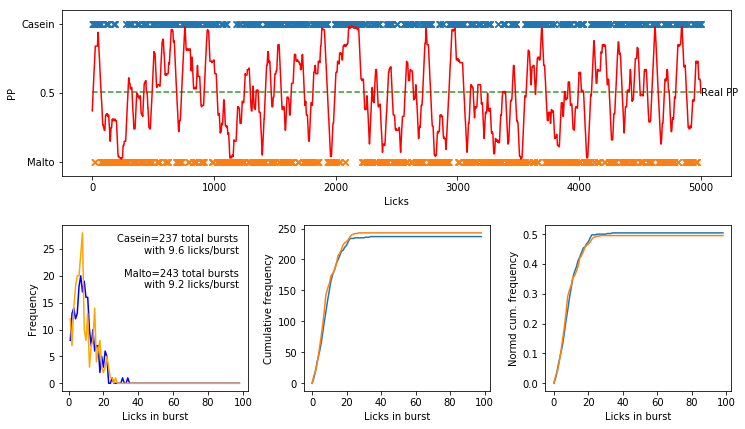

In [8]:
makeSessionFig(lickdata)

In [37]:
histbins = np.arange(0,100)
beta=0.3
intercept=0.7

alpha_array = np.arange(1, 102, 10)

casbursts_array = []
maltbursts_array = []

casburstsMax_array = []
maltburstsMax_array = []

for alpha in alpha_array:

    licks = runmodel(alpha, beta, intercept, 5000)
    lickdata = analyse_licks(licks, histbins)

    casbursts_array.append(np.mean(lickdata['bursts'][1]))
    maltbursts_array.append(np.mean(lickdata['bursts'][0]))
    
    casburstsMax_array.append(np.max(lickdata['bursts'][1]))
    maltburstsMax_array.append(np.max(lickdata['bursts'][0]))


C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


Text(0.1, 0.9, 'Maltodextrin')

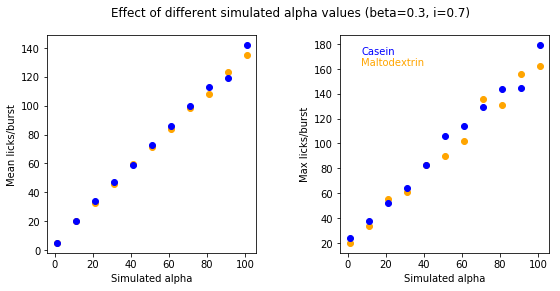

In [38]:
f, ax = plt.subplots(figsize=(9,4), ncols=2)
f.subplots_adjust(wspace=0.4)
f.suptitle('Effect of different simulated alpha values (beta={0}, i={1})'.format(beta, intercept))

ax[0].plot(alpha_array, casbursts_array, 'o', color='orange')
ax[0].plot(alpha_array, maltbursts_array, 'o', color='blue')


ax[1].plot(alpha_array, casburstsMax_array, 'o', color='orange')
ax[1].plot(alpha_array, maltburstsMax_array, 'o', color='blue')

for axis in [ax[0], ax[1]]:
    axis.set_xlabel('Simulated alpha')
    
ax[0].set_ylabel('Mean licks/burst')

ax[1].set_ylabel('Max licks/burst')
ax[1].text(0.1, 0.95, 'Casein', color='blue', transform=ax[1].transAxes, ha='left', va='top')
ax[1].text(0.1, 0.90, 'Maltodextrin', color='orange', transform=ax[1].transAxes, ha='left', va='top')

# savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
# f.savefig(savefolder+'sim_PPvals.png')

In [23]:
histbins = np.arange(0,100)
alpha=40
intercept=0.3

beta_array = np.arange(0.1, 1.1, 0.1)

casbursts_array = []
maltbursts_array = []

casburstsMax_array = []
maltburstsMax_array = []

for beta in beta_array:

    licks = runmodel(alpha, beta, intercept, 5000)
    lickdata = analyse_licks(licks, histbins)

    casbursts_array.append(np.mean(lickdata['bursts'][1]))
    maltbursts_array.append(np.mean(lickdata['bursts'][0]))
    
    casburstsMax_array.append(np.max(lickdata['bursts'][1]))
    maltburstsMax_array.append(np.max(lickdata['bursts'][0]))

Text(0.1, 0.1, 'Maltodextrin')

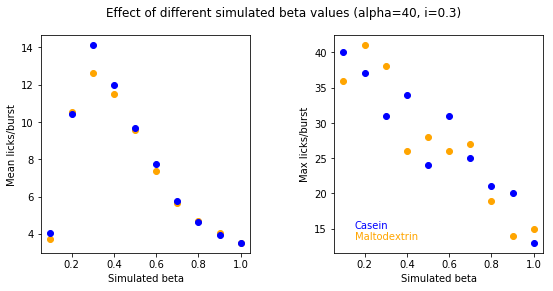

In [27]:
f, ax = plt.subplots(figsize=(9,4), ncols=2)
f.subplots_adjust(wspace=0.4)
f.suptitle('Effect of different simulated beta values (alpha={0}, i={1})'.format(alpha, intercept))

ax[0].plot(beta_array, casbursts_array, 'o', color='orange')
ax[0].plot(beta_array, maltbursts_array, 'o', color='blue')


ax[1].plot(beta_array, casburstsMax_array, 'o', color='orange')
ax[1].plot(beta_array, maltburstsMax_array, 'o', color='blue')

for axis in [ax[0], ax[1]]:
    axis.set_xlabel('Simulated beta')
    
ax[0].set_ylabel('Mean licks/burst')

ax[1].set_ylabel('Max licks/burst')
ax[1].text(0.1, 0.15, 'Casein', color='blue', transform=ax[1].transAxes, ha='left', va='top')
ax[1].text(0.1, 0.10, 'Maltodextrin', color='orange', transform=ax[1].transAxes, ha='left', va='top')

# savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
# f.savefig(savefolder+'sim_PPvals.png')

In [34]:
histbins = np.arange(0,100)
alpha=40
beta=0.3

intercept_array = np.arange(0.05, 1.1, 0.1)

casbursts_array = []
maltbursts_array = []

casburstsMax_array = []
maltburstsMax_array = []

for i in intercept_array:

    licks = runmodel(alpha, beta, intercept, 5000)
    lickdata = analyse_licks(licks, histbins)

    casbursts_array.append(np.mean(lickdata['bursts'][1]))
    maltbursts_array.append(np.mean(lickdata['bursts'][0]))
    
    casburstsMax_array.append(np.max(lickdata['bursts'][1]))
    maltburstsMax_array.append(np.max(lickdata['bursts'][0]))

Text(0.1, 0.1, 'Maltodextrin')

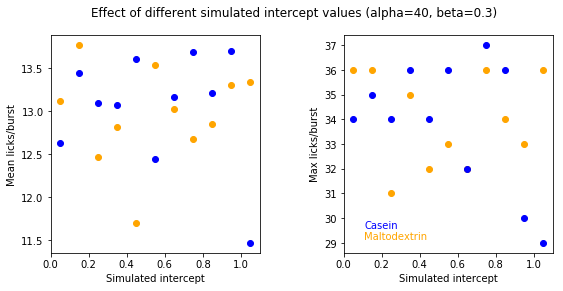

In [36]:
f, ax = plt.subplots(figsize=(9,4), ncols=2)
f.subplots_adjust(wspace=0.4)
f.suptitle('Effect of different simulated intercept values (alpha={0}, beta={1})'.format(alpha, beta))

ax[0].plot(intercept_array, casbursts_array, 'o', color='orange')
ax[0].plot(intercept_array, maltbursts_array, 'o', color='blue')


ax[1].plot(intercept_array, casburstsMax_array, 'o', color='orange')
ax[1].plot(intercept_array, maltburstsMax_array, 'o', color='blue')

for axis in [ax[0], ax[1]]:
    axis.set_xlabel('Simulated intercept')
    
ax[0].set_ylabel('Mean licks/burst')

ax[1].set_ylabel('Max licks/burst')
ax[1].text(0.1, 0.15, 'Casein', color='blue', transform=ax[1].transAxes, ha='left', va='top')
ax[1].text(0.1, 0.10, 'Maltodextrin', color='orange', transform=ax[1].transAxes, ha='left', va='top')

# savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
# f.savefig(savefolder+'sim_PPvals.png')

In [30]:
intercept_array = np.arange(0.05, 0.9, 0.05)

In [31]:
intercept_array

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85])